### Imports

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD

2022-11-10 22:13:09.275774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 22:13:09.363774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 22:13:09.363787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-10 22:13:09.384799: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 22:13:09.824597: W tensorflow/stream_executor/platform/de

### Load dataset

In [2]:
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Exploding Gradients and Clipping

Neural networks are trained using the stochastic gradient descent optimization algorithm.

This requires first the estimation of the loss on one or more training examples, then the calculation of the derivative of the loss, which is propagated backward through the network in order to update the weights. Weights are updated using a fraction of the back propagated error controlled by the learning rate.

It is possible for the updates to the weights to be so large that the weights either overflow or underflow their numerical precision. In practice, the weights can take on the value of an “NaN” or “Inf” when they overflow or underflow and for practical purposes the network will be useless from that point forward, forever predicting NaN values as signals flow through the invalid weights.

In a given neural network, such as a Convolutional Neural Network or Multilayer Perceptron, this can happen due to a poor choice of configuration. Some examples include:

- Poor choice of learning rate that results in large weight updates.
- Poor choice of data preparation, allowing large differences in the target variable.
- Poor choice of loss function, allowing the calculation of large error values.

Exploding gradients is also a problem in recurrent neural networks such as the Long Short-Term Memory network given the accumulation of error gradients in the unrolled recurrent structure.

Exploding gradients can be avoided in general by careful configuration of the network model, such as choice of small learning rate, scaled target variables, and a standard loss function. Nevertheless, exploding gradients may still be an issue with recurrent networks with a large number of input time steps.

A common solution to exploding gradients is to change the error derivative before propagating it backward through the network and using it to update the weights. By rescaling the error derivative, the updates to the weights will also be rescaled, dramatically decreasing the likelihood of an overflow or underflow.

There are two main methods for updating the error derivative; they are:

- Gradient Scaling.
- Gradient Clipping.

Gradient scaling involves normalizing the error gradient vector such that vector norm (magnitude) equals a defined value, such as 1.0.

Gradient clipping involves forcing the gradient values (element-wise) to a specific minimum or maximum value if the gradient exceeded an expected range.

Together, these methods are often simply referred to as “gradient clipping.”

### Gradient Clipping in Keras

Keras support Gradient Clipping on each optimization algorithm, with the same scheme applied to all layers in the model.

Gradient clipping can be used with an optimization algorithm, such as stochastic gradient descent, via including an additional argument when configuring the optimization algorithm.

Two types of gradient clipping can be used: Gradient Norm Scaling and Gradient Value Clipping.

### Gradient Norm Scaling

Gradient Norm Scaling involves changing the derivatives of the loss function to have a given vector norm when the L2 vector norm (sum of the squared values) of the gradient vector exceeds a threshold value.

For example, we could specify a norm of 1.0, meaning that if the vector norm for a gradient exceeds 1.0, then the values in the vector will be rescaled so that the norm of the vector equals 1.0.

### Gradient Value Clipping

Gradient Value Clipping involves clipping the derivatives of the loss function to have a given value if a gradient value is less than a negative threshold or more than the positive threshold.

For example, we could specify a norm of 0.5, meaning that if a gradient value was less than -0.5, it is set to -0.5 and if it is more than 0.5, then it will be set to 0.5.

### 1. Training the model - MLP with exploding gradients

In [3]:
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01, momentum=0.9))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

2022-11-10 22:13:10.329731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-10 22:13:10.329765: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-10 22:13:10.329793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fabio-XPS-15-7590): /proc/driver/nvidia/version does not exist
2022-11-10 22:13:10.330092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Evaluate the model

In [4]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(test_mse)

nan


### Plot loss

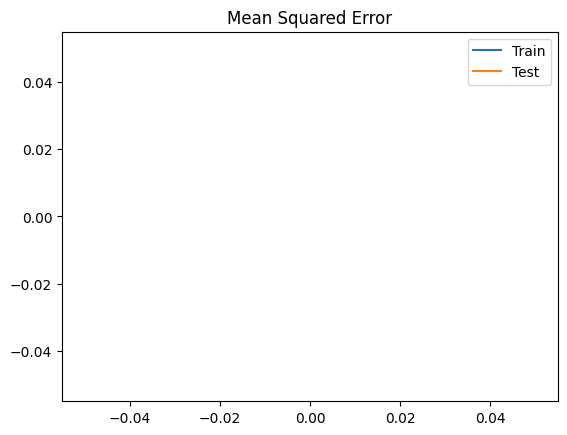

In [5]:
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

### 2. Training the model - MLP with Gradient Norm Scaling

In [6]:
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.0))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

In [7]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(test_mse)

2.2428340911865234


### Plot loss

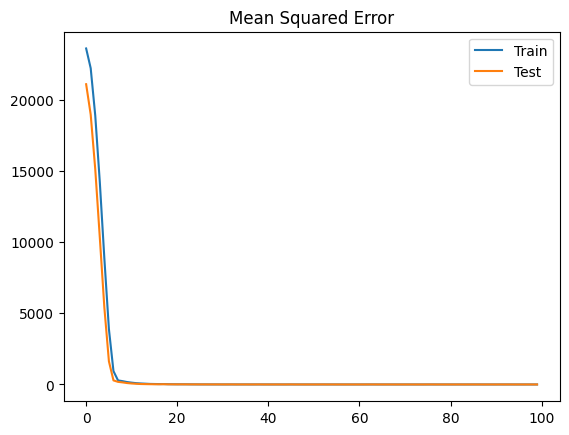

In [8]:
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

### 3. Training the model - MLP with Gradient Value Clipping

In [9]:
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01, momentum=0.9, clipvalue=5.0))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

In [10]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(test_mse)

28.700298309326172


### Plot loss

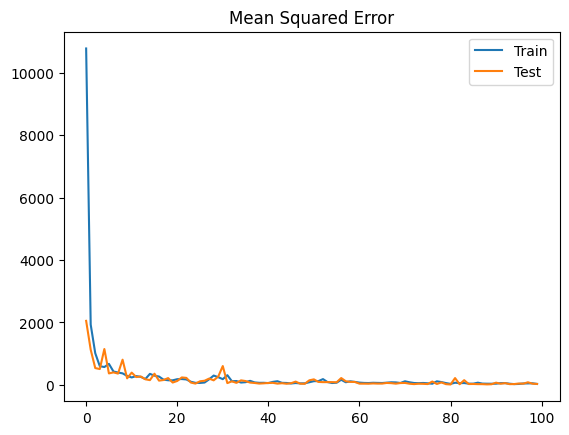

In [11]:
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()